## What we want to try to do:

### Data annotation and preprocessing from "Nonverbal Sound Detection for Disordered Speech":

* Each mouth sound recording contains repeated instances of one sound type with silence in between. 
* Make labels for each frame by computing the energy in the audio signal and finding segments with minimum duration of 30 ms and whose relative energy exceeded one standard deviation from the mean. 
    - All frames within a given segment were labeled with the user-annotated sound type and all others were considered "silence."
* Labels for speech clips were generated using a speech activity detector and all aggressor clip frames were labeled with the background class.

### Data pipeline:
    
> 300ms window of 16 hz sound recordings -> 64 dimensional log mel-spectrograms generated with a 25 ms window and stride of 10 ms, resulting in a 100 hz sampling rate.

### Other things to note 
Don't forget to normalize volume!

If you have issues with ffmpeg, you might need to uninstall it (with `<conda/mamba> uninstall ffmpeg --force`) and then reinstall it in the conda env.

## Reproducing their Data Annotation Step

1. Find segments with min duration 30ms and whose relative energy > mean. Call these `tgt_segments`
2. Split all segments into frames, both `tgt_segments` and non-target ones.
3. Annotate frames of `tgt_segments` with the sound type, and annotate all other frames as 'silence'

#### Useful resources:

On silence splitting:
* https://medium.com/@vvk.victory/audio-processing-librosa-split-on-silence-8e1edab07bbb
* https://musicinformationretrieval.com/energy.html
* https://hackernoon.com/audio-handling-basics-how-to-process-audio-files-using-python-cli-jo283u3y
* https://stackoverflow.com/questions/45526996/split-audio-files-using-silence-detection

On splitting into frames:
* https://groups.google.com/g/librosa/c/eQMGmyjObyk

Let's first try a quick toy example.

In [63]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pydub import AudioSegment
from pydub.utils import make_chunks
from pydub.silence import split_on_silence, detect_nonsilent, detect_silence
import librosa
import librosa.display
import IPython.display as ipd

import itertools as itools
from functools import partial
from collections import namedtuple
from dataclasses import asdict, dataclass, field
from typing import Optional, List, Any, Callable, Generator, Dict

# sns theme from Medallion Data Science
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = itools.cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [4]:
# trying to track down pydub issues...
import logging
logger = logging.getLogger("pydub.converter")
logger.setLevel(logging.DEBUG)
logger.addHandler(logging.StreamHandler())

In [5]:
PATH_ALVCLICK = Path("../data/toy_data/05a15-alv-click-1.m4a")

In [8]:
#alvclick_y, alvclick_sr = librosa.load(str(PATH_ALVCLICK))  
alvclick = AudioSegment.from_file(str(PATH_ALVCLICK))

subprocess.call(['ffmpeg', '-y', '-i', '../data/toy_data/05a15-alv-click-1.m4a', '-acodec', 'pcm_s16le', '-vn', '-f', 'wav', '-'])


In [56]:
len(nonsilent_segments_with_default_threshold)

32

#### a. Split into audio segments; get the mean dBFS over all the segments and the SD

In [68]:

chunk_len_ms = 30 
chunks = make_chunks(alvclick, chunk_len_ms)
chunk_dBFSes = [chunk.dBFS for chunk in chunks]

mean_dBFS: -76.35081651339331, std: 8.893269827514223, median: -78.2677988726351


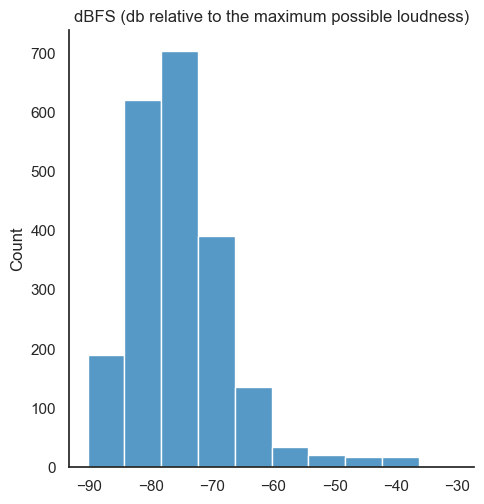

In [57]:
mean_dBFS, std_dBFS, median_dBFS = np.mean(chunk_dBFSes), np.std(chunk_dBFSes), np.median(chunk_dBFSes)
print(f"mean_dBFS: {mean_dBFS}, std: {std_dBFS}, median: {median_dBFS}")
sns.displot(data=chunk_dBFSes, binwidth=6)
plt.title("dBFS (db relative to the maximum possible loudness)")
plt.show()

Re dBFS: A Square wave at maximum amplitude will be roughly 0 dBFS (maximum loudness), whereas a Sine Wave at maximum amplitude will be roughly -3 dBFS.

Let's first try getting a list of all non-silent sections [start, end] in milliseconds, using the pydub `detect_nonsilent` function. This will allow us to get a sense for `pydub` and the various settings, and serve as a quick sanity check.

In [61]:
min_silence_len_ms = 650 # I didn't always suceed at waiting long enough 
silence_upper_bound_dbfs = median_dBFS + std_dBFS # anything quieter than this --- i.e., anything with a lower dBFS --- will be considered silence
nonsilent_segments = detect_nonsilent(alvclick, min_silence_len_ms, silence_upper_bound_dbfs)
print(f"number of non silent segments:", len(nonsilent_segments))
nonsilent_segments
# this takes quite a while

number of non silent segments: 32


[[829, 1054],
 [2483, 2525],
 [4353, 4399],
 [6346, 6383],
 [8349, 8382],
 [10273, 10310],
 [12236, 12255],
 [14402, 14437],
 [16717, 16758],
 [18593, 18600],
 [20462, 20499],
 [22385, 22498],
 [24551, 24678],
 [26656, 26693],
 [28778, 28824],
 [30860, 30925],
 [32667, 32780],
 [34455, 34509],
 [36320, 36521],
 [38521, 38562],
 [40620, 40640],
 [42512, 42533],
 [44862, 45537],
 [46601, 46733],
 [48545, 48839],
 [50954, 50996],
 [52959, 52981],
 [54732, 54774],
 [56468, 56504],
 [58539, 58569],
 [60376, 60405],
 [61371, 62891]]

In [67]:
# To use for verifying the cheap function:
silent_segments =  detect_silence(alvclick, min_silence_len_ms, silence_upper_bound_dbfs)
print(len(silent_segments))
silent_segments

# ok so it looks like the right endpoint is exclusive

33


[[0, 829],
 [1054, 2483],
 [2525, 4353],
 [4399, 6346],
 [6383, 8349],
 [8382, 10273],
 [10310, 12236],
 [12255, 14402],
 [14437, 16717],
 [16758, 18593],
 [18600, 20462],
 [20499, 22385],
 [22498, 24551],
 [24678, 26656],
 [26693, 28778],
 [28824, 30860],
 [30925, 32667],
 [32780, 34455],
 [34509, 36320],
 [36521, 38521],
 [38562, 40620],
 [40640, 42512],
 [42533, 44862],
 [45537, 46601],
 [46733, 48545],
 [48839, 50954],
 [50996, 52959],
 [52981, 54732],
 [54774, 56468],
 [56504, 58539],
 [58569, 60376],
 [60405, 61371],
 [62891, 63807]]

Looks like the number of non-silent sections that we get when we look for segments that are louder than the median + 1 SD are about what we'd expect. 

So now we just need a function that gives us the inverse sections in a cheap way, so that we have both sorts of sections.

#### b. Find segments with min duration 30ms and whose relative energy > mean. Call these `tgt_segments`


In [ ]:
# ok now filter out the sections with duration < 30ms
# and get the silent sections too...

In [ ]:
# 3. Split all segments into frames, both `tgt_segments` and non-target ones.
# 4. Annotate frames of `tgt_segments` with the sound type, and annotate all other frames as 'silence'
# mean_dBFS = audio_segment.dBFS


c. Split all segments into frames, both `tgt_segments` and non-target ones.

In [ ]:
#frames = librosa.util.frame(alvclick_y, frame_length=2048, hop_length=64)


d. Annotate frames of `tgt_segments` with the sound type, and annotate all other frames as 'silence'